# Galaxies vs quasars

#### Tasks

The dataset is at `solutions/galaxyquasar.csv` (I extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

##### Food for thought
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?



In [1]:
import emcee
import corner
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from astropy.table import Table

from astroML.utils import completeness_contamination
from astroML.utils.decorators import pickle_results
from astroML.utils import split_samples
from astroML.classification import GMMBayes
from astroML.resample import bootstrap

from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay
#from astroML.classification import GaussianMixture as GMMBayes

# Data fetch and visualization

In [2]:
filename = "../solutions/galaxyquasar.csv"
table = Table.read(filename)

In [3]:
table

u,g,r,i,z,class,z1,zerr
float64,float64,float64,float64,float64,str6,float64,float64
18.97213,18.53676,18.5828,18.34936,18.29215,QSO,0.5228189,0.0001547483
19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.1228459,2.816076e-05
19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.0,0.0
19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.1474355,9.310701e-06
19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.0006307968
17.60994,15.90911,15.0209,14.54955,14.19971,GALAXY,0.04619161,1.022329e-05
...,...,...,...,...,...,...,...
16.8205,14.99753,14.18414,13.79698,13.51894,GALAXY,0.0291452,9.240287e-06
19.33829,17.77267,16.95998,16.56725,16.25636,GALAXY,0.05180373,1.632631e-05


In [4]:
u_g = table["u"] - table["g"]
g_r = table["g"] - table["r"]
r_i = table["r"] - table["i"]
i_z = table["i"] - table["z"]

labels = table["class"]

In [5]:
labels_z_o = np.where(labels=="QSO", 1, 0)

In [6]:
N_dim_dataset = np.array([u_g, g_r, r_i, i_z]).T

In [7]:
N_dim_dataset.shape

(50000, 4)

I try to visualize the different histograms of data with the true labels:

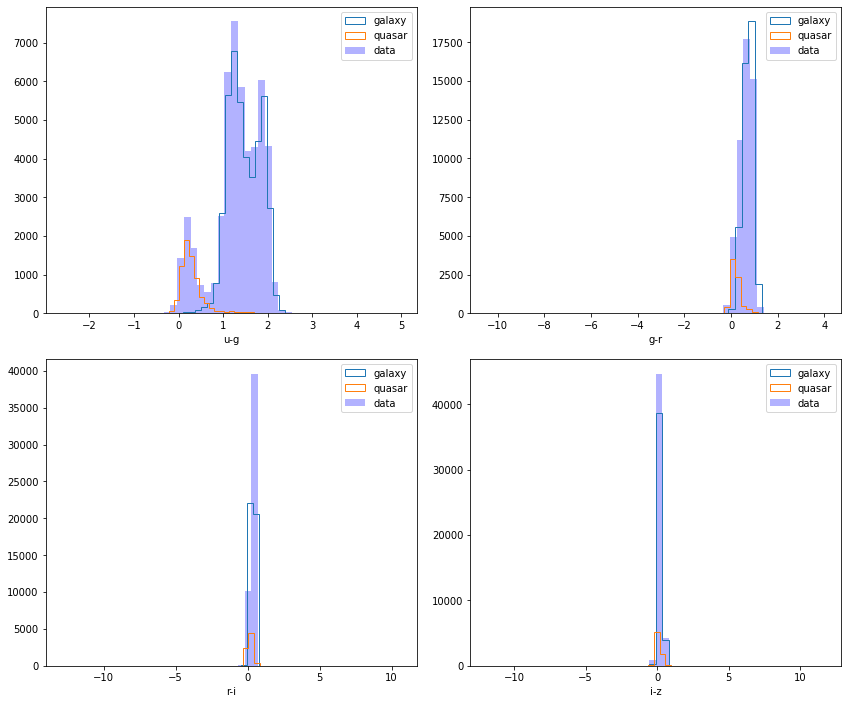

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

labels=["u-g", "g-r", "r-i", "i-z"]

for ax, data, xlabel in zip(axs.flatten(), N_dim_dataset.T, labels):
    
    ax.hist(data[labels_z_o==0], bins=50, histtype = 'step', label = 'galaxy', lw=1)
    ax.hist(data[labels_z_o==1], bins=50, histtype = 'step', label = 'quasar', lw=1)
    ax.hist(data, bins=50, label = 'data', color='blue', alpha=0.3)
    ax.legend()
    ax.set_xlabel(xlabel)
    
plt.tight_layout(pad=1.5);

The only one showing off most of the bimodality seems to be the $u-g$ projection so I am first going to investigate it before extending the analysis to the whole dataset.

# Classification

Split the train and validation test:

In [9]:
X_train, X_validation, y_train, y_validation = train_test_split(u_g, labels_z_o, test_size=0.33, random_state=1)

# AD == all data

X_train_AD, X_validation_AD, y_train_AD, y_validation_AD =  train_test_split(N_dim_dataset, labels_z_o, test_size=0.33, random_state=1)

## LDA

- 1-dimensional analysis: 

In [10]:
lda = LDA()
lda.fit(X_train[:, None], y_train)
y_pred_lda = lda.predict(X_validation[:, None])

In [11]:
y_score = lda.decision_function(X_validation[:, None])

In [12]:
completenessLDA, contaminationLDA = completeness_contamination(y_pred_lda, y_validation)

print("completeness", completenessLDA)
print("contamination", contaminationLDA)

completeness 0.9382871536523929
contamination 0.06797331109257715


- N-dimensional analysis:

In [13]:
lda_AD = LDA()
lda_AD.fit(X_train_AD, y_train_AD)
y_pred_lda_AD = lda_AD.predict(X_validation_AD)

In [14]:
y_score_AD = lda_AD.decision_function(X_validation_AD)

In [15]:
completenessLDA_AD, contaminationLDA_AD = completeness_contamination(y_pred_lda_AD, y_validation_AD)

print("completeness", completenessLDA_AD)
print("contamination", contaminationLDA_AD)

completeness 0.9357682619647355
contamination 0.06147368421052631


### ROC curve

- 1-dimensional analysis

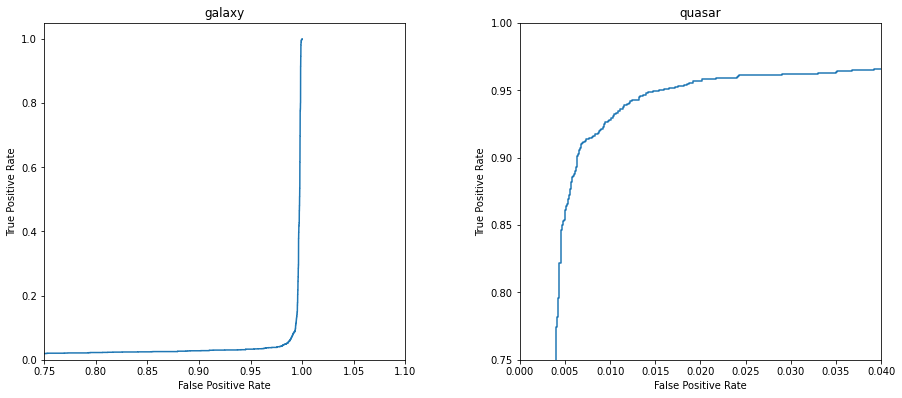

In [16]:
y_score_LDA = [ lda.predict_proba(X_validation[:, None])[:, 0], lda.predict_proba(X_validation[:, None])[:, 1]]

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i, obj in zip(range(0, 2), ['galaxy', 'quasar']):
    
    fpr_i, tpr_i, _ = roc_curve(y_validation_AD, y_score_LDA[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr_i, tpr=tpr_i).plot(ax=axs[i])
    
    axs[i].set_title(f"{obj}")
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")
    
# better visualization:
    
axs[1].set_xlim(0, 0.04) 
axs[1].set_ylim(0.75, 1)  

axs[0].set_xlim(0.75, 1.1) 
axs[0].set_ylim(0, 1.05)  

    
plt.tight_layout(pad=6.0)  # spacing between subplots

plt.show()

### Very important thought I had on the ROC curve: 
The fact that for galaxies we have the opposite of the nice curve we have for the quasars does not indicate that the classifier is not capable to classify them. Instead the fact that the ROC curve is based on a binary sampling here is reflected into the implementation where we only use the ***true positive***  rate, and not the ***true negative*** rate. If we chose to have the index of galaxies to be the true positive, then I think we'd have the opposite behaviour.

- N-dimensional analysis

In [17]:
y_score_LDA_AD = np.array([lda_AD.predict_proba(X_validation_AD)[:, i] for i in range(0, 2)])

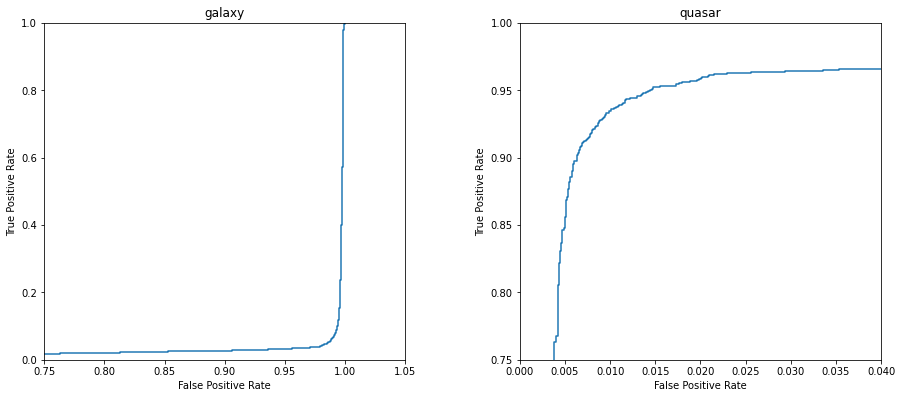

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i, obj in zip(range(0, 2), ['galaxy', 'quasar']):
    
    fpr_i, tpr_i, _ = roc_curve(y_validation_AD, y_score_LDA_AD[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr_i, tpr=tpr_i).plot(ax=axs[i])
    
    axs[i].set_title(f"{obj}")
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")
    
# better visualization:
    
axs[1].set_xlim(0, 0.04) 
axs[1].set_ylim(0.75, 1)  

axs[0].set_xlim(0.75, 1.05) 
axs[0].set_ylim(0, 1)  

plt.tight_layout(pad=6.0)  # spacing between subplots

plt.show()

## QDA

- 1-dimensional analysis

In [19]:
qda = QDA()
qda.fit(X_train[:, None], y_train)
y_pred_qda = qda.predict(X_validation[:, None])

In [20]:
completenessQDA, contaminationQDA = completeness_contamination(y_pred_qda, y_validation)


print("completeness", completenessQDA)
print("contamination", contaminationQDA)

completeness 0.9370277078085643
contamination 0.06727956539908066


- N-dimensional analysis

In [21]:
qda_AD = QDA()
qda_AD.fit(X_train_AD, y_train_AD)
y_pred_qda_AD = qda_AD.predict(X_validation_AD)

In [22]:
y_score_AD = qda_AD.decision_function(X_validation_AD)

In [23]:
completenessQDA_AD, contaminationQDA_AD = completeness_contamination(y_pred_qda_AD, y_validation_AD)

print("completeness", completenessQDA_AD)
print("contamination", contaminationQDA_AD)

completeness 0.9231738035264484
contamination 0.06505102040816327


### ROC curve

- 1-dimensional analysis

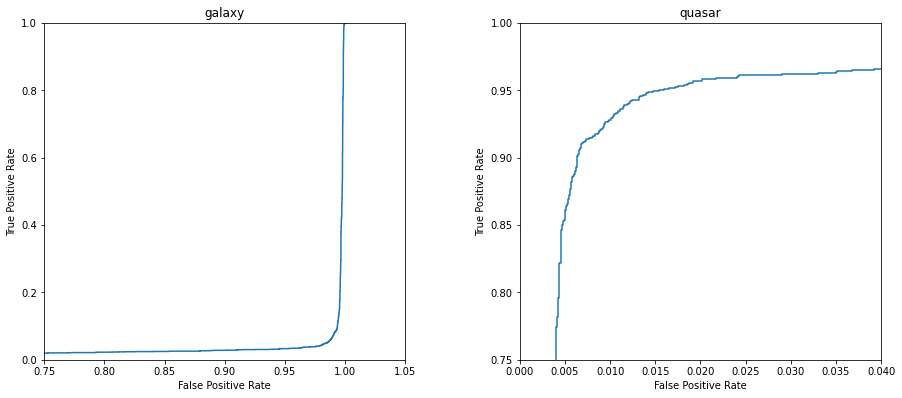

In [24]:
y_score_QDA = [qda.predict_proba(X_validation[:, None])[:, 0], qda.predict_proba(X_validation[:, None])[:, 1]]

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i, obj in zip(range(0, 2), ['galaxy', 'quasar']):
    
    fpr_i, tpr_i, _ = roc_curve(y_validation_AD, y_score_QDA[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr_i, tpr=tpr_i).plot(ax=axs[i])
    
    axs[i].set_title(f"{obj}")
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")

# better visualization:
    
axs[1].set_xlim(0, 0.04) 
axs[1].set_ylim(0.75, 1)  

axs[0].set_xlim(0.75, 1.05) 
axs[0].set_ylim(0, 1)  

    
plt.tight_layout(pad=6.0)  # spacing between subplots

plt.show()

- N-dimensional analysis

In [25]:
y_score_QDA_AD = np.array([qda_AD.predict_proba(X_validation_AD)[:, i] for i in range(0, 2)])

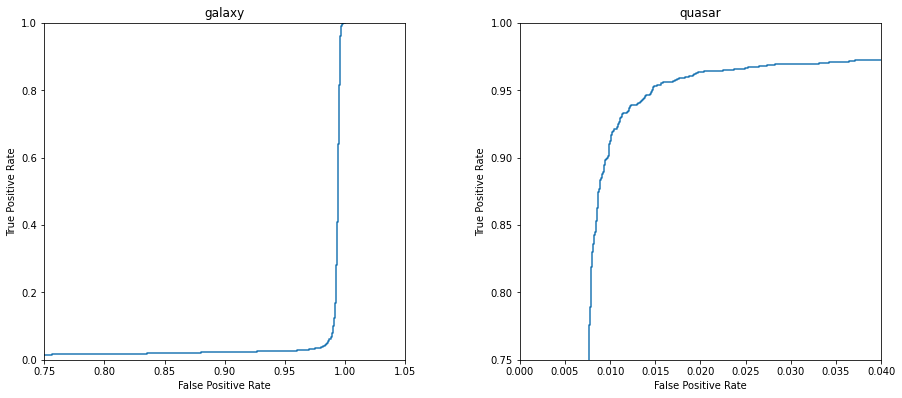

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i, obj in zip(range(0, 2), ['galaxy', 'quasar']):
    
    fpr_i, tpr_i, _ = roc_curve(y_validation_AD, y_score_QDA_AD[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr_i, tpr=tpr_i).plot(ax=axs[i])
    
    axs[i].set_title(f"{obj}")
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")
    
# better visualization:
    
axs[1].set_xlim(0, 0.04) 
axs[1].set_ylim(0.75, 1)  

axs[0].set_xlim(0.75, 1.05) 
axs[0].set_ylim(0, 1) 
    
plt.tight_layout(pad=6.0)  # spacing between subplots

plt.show()

## GMM

- 1-dimensional analysis
### What is the correct number of Gaussians to set?

In [27]:
scores = []
kvals = np.arange(2,20)

for k in kvals:
    
    clf = GMMBayes(k)
    CVpredk = cross_val_predict(clf, X_validation[:, None], y_validation)
    scores.append(accuracy_score(y_validation, CVpredk)) 

max score is for k=3


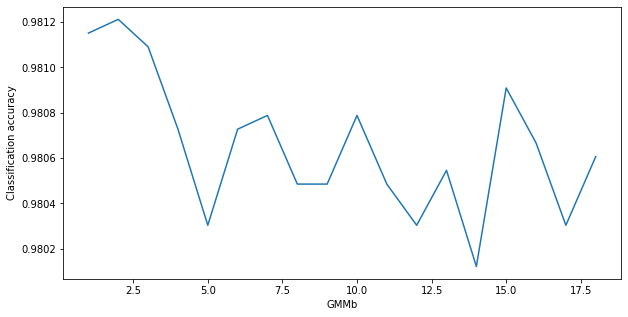

In [28]:
print("max score is for k={:d}".format(kvals[np.argmax(scores)]))

# Plot number of neighbors vs score
fig = plt.figure(figsize=(10, 5))
u = np.arange(len(scores))+1
plt.plot(u,scores)
plt.xlabel('GMMb')
plt.ylabel('Classification accuracy');

Set the classifier:

In [29]:
gmmb = GMMBayes(kvals[np.argmax(scores)]) 
gmmb.fit(X_train[:, None], y_train)

y_pred_gmm = gmmb.predict(X_validation[:, None])

In [30]:
completenessGMM, contaminationGMM = completeness_contamination(y_pred_gmm, y_validation)

print("completeness", completenessGMM)
print("contamination", contaminationGMM)

completeness 0.9227539882451721
contamination 0.057057057057057055


- N-dimensional analysis

### What is the correct number of Gaussians to set?

In [31]:
scores_N = []
kvals = np.arange(2,20)

for k in kvals:
    
    clf = GMMBayes(k)
    CVpredk = cross_val_predict(clf, X_validation_AD, y_validation_AD)
    scores_N.append(accuracy_score(y_validation_AD, CVpredk)) 

max score is for k=19


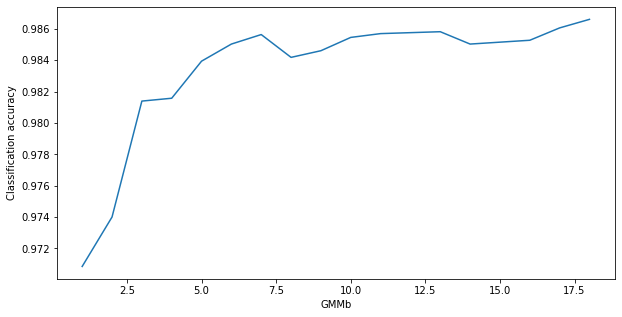

In [32]:
print("max score is for k={:d}".format(kvals[np.argmax(scores_N)]))

# Plot number of neighbors vs score
fig = plt.figure(figsize=(10, 5))
u = np.arange(len(scores_N))+1
plt.plot(u,scores_N)
plt.xlabel('GMMb')
plt.ylabel('Classification accuracy');

Set the classifier:

In [33]:
gmmb_AD = GMMBayes(kvals[np.argmax(scores_N)])
gmmb_AD.fit(X_train_AD, y_train_AD)
y_pred_gmmb_AD = gmmb_AD.predict(X_validation_AD)

In [34]:
completenessGMM_AD, contaminationGMM_AD = completeness_contamination(y_pred_gmmb_AD, y_validation_AD)

print("completeness", completenessGMM_AD)
print("contamination", contaminationGMM_AD)

completeness 0.9508816120906801
contamination 0.04951741502308015


### ROC curve:

- 1-dimensional analysis

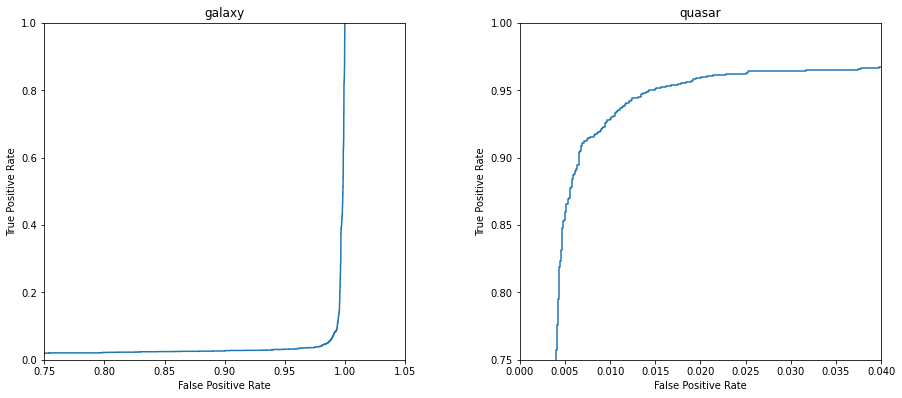

In [35]:
y_score_GMMB =  [gmmb.predict_proba(X_validation[:, None])[:, 0], gmmb.predict_proba(X_validation[:, None])[:, 1]]

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i, obj in zip(range(0, 2), ['galaxy', 'quasar']):
    
    fpr, tpr, _ = roc_curve(y_validation, y_score_GMMB[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[i])
    
    axs[i].set_title(f"{obj}")
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")

# better visualization:
    
axs[1].set_xlim(0, 0.04) 
axs[1].set_ylim(0.75, 1)  

axs[0].set_xlim(0.75, 1.05) 
axs[0].set_ylim(0, 1) 

plt.tight_layout(pad=6.0)  # spacing between subplots

plt.show()

- N-dimensional analysis

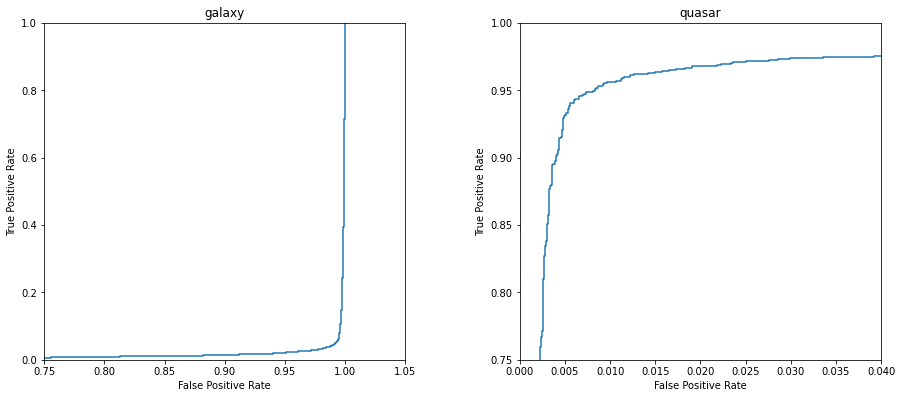

In [36]:
y_score_GMM_AD = np.array([gmmb_AD.predict_proba(X_validation_AD)[:, i] for i in range(0, 2)])

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i, obj in zip(range(0, 2), ['galaxy', 'quasar']):
    
    fpr, tpr, _ = roc_curve(y_validation, y_score_GMM_AD[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[i])
    
    axs[i].set_title(f"{obj}")
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")

# better visualization:
    
axs[1].set_xlim(0, 0.04) 
axs[1].set_ylim(0.75, 1)  

axs[0].set_xlim(0.75, 1.05) 
axs[0].set_ylim(0, 1) 
    
plt.tight_layout(pad=6.0)  # spacing between subplots

plt.show()

## K-Nearest neighbors

- 1-dimensional analysis
### What is the correct number of neighbors to set?

In [37]:
import warnings
warnings.filterwarnings("ignore")  # avoid warnings being displayed

In [38]:
scores = []
kvals = np.arange(1,20)

for k in kvals:
    clf = KNeighborsClassifier(n_neighbors=k)
    CVpredk = cross_val_predict(clf, X_validation[:, None], y_validation)
    scores.append(accuracy_score(y_validation, CVpredk)) 

max score is for k=19


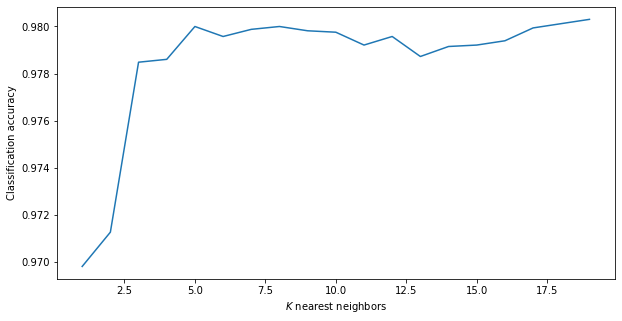

In [39]:
print("max score is for k={:d}".format(kvals[np.argmax(scores)]))

# Plot number of neighbors vs score
fig = plt.figure(figsize=(10, 5))
u = np.arange(len(scores))+1
plt.plot(u,scores)
plt.xlabel('$K$ nearest neighbors')
plt.ylabel('Classification accuracy');

In [40]:
knc = KNeighborsClassifier(kvals[np.argmax(scores)]) 
knc.fit(X_train[:, None], y_train)

y_pred_knc = knc.predict(X_validation[:, None])

In [41]:
completenessKN, contaminationKN = completeness_contamination(y_pred_knc, y_validation)

print("completeness", completenessKN)
print("contamination", contaminationKN)

completeness 0.9387069689336692
contamination 0.06949646275488972


- N-dimensional analysis
### What is the correct number of neighbors to set?

In [42]:
scores = []
kvals = np.arange(1,20)

for k in kvals:
    clf = KNeighborsClassifier(n_neighbors=k)
    CVpredk = cross_val_predict(clf, X_validation_AD, y_validation_AD)
    scores.append(accuracy_score(y_validation_AD, CVpredk)) 

max score is for k=7


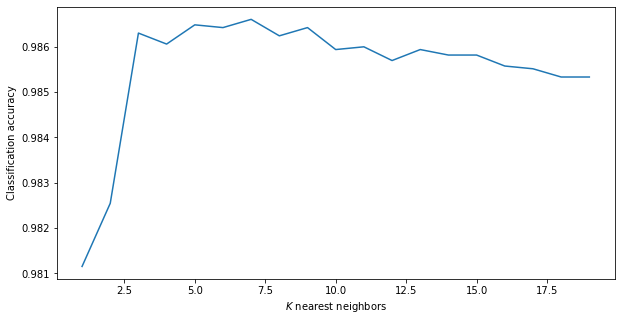

In [43]:
print("max score is for k={:d}".format(kvals[np.argmax(scores)]))

# Plot number of neighbors vs score
fig = plt.figure(figsize=(10, 5))
u = np.arange(len(scores))+1
plt.plot(u,scores)
plt.xlabel('$K$ nearest neighbors')
plt.ylabel('Classification accuracy');

In [44]:
kn_AD = KNeighborsClassifier(kvals[np.argmax(scores)])
kn_AD.fit(X_train_AD, y_train_AD)
y_pred_kn_AD = kn_AD.predict(X_validation_AD)

completenessKN_AD, contaminationKN_AD = completeness_contamination(y_pred_kn_AD, y_validation_AD)

print("completeness", completenessKN_AD)
print("contamination", contaminationKN_AD)

completeness 0.9504617968094039
contamination 0.04391891891891892


### ROC curve

- 1-dimensional analysis

In [45]:
y_score_KN = [knc.predict_proba(X_validation[:, None])[:, 0], knc.predict_proba(X_validation[:, None])[:, 1]]

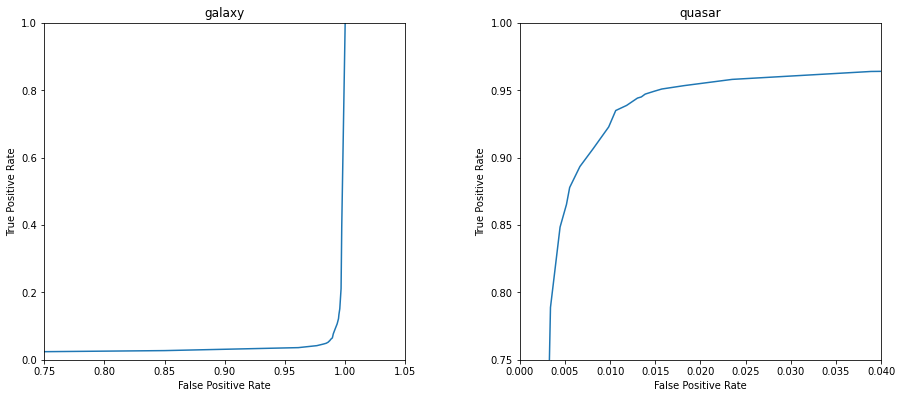

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i, obj in zip(range(0, 2), ['galaxy', 'quasar']):
    
    fpr, tpr, _ = roc_curve(y_validation, y_score_KN[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[i])
    
    axs[i].set_title(f"{obj}")
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")
    
# better visualization:
    
axs[1].set_xlim(0, 0.04) 
axs[1].set_ylim(0.75, 1)  

axs[0].set_xlim(0.75, 1.05) 
axs[0].set_ylim(0, 1) 

    
plt.tight_layout(pad=6.0)  # spacing between subplots

plt.show()

- N-dimensional analysis

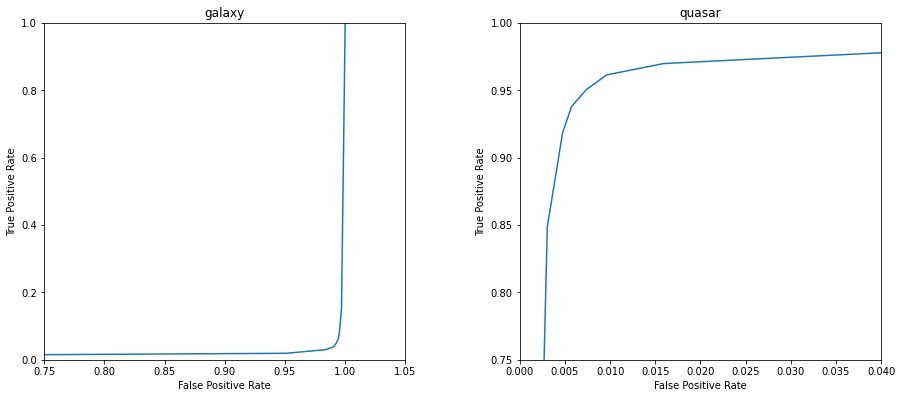

In [47]:
y_score_KN_AD = [kn_AD.predict_proba(X_validation_AD)[:, 0], kn_AD.predict_proba(X_validation_AD)[:, 1]]


fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i, obj in zip(range(0, 2), ['galaxy', 'quasar']):
    
    fpr, tpr, _ = roc_curve(y_validation_AD, y_score_KN_AD[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[i])
    
    axs[i].set_title(f"{obj}")
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")

# better visualization:
    
axs[1].set_xlim(0, 0.04) 
axs[1].set_ylim(0.75, 1)  

axs[0].set_xlim(0.75, 1.05) 
axs[0].set_ylim(0, 1) 

    
plt.tight_layout(pad=6.0)  # spacing between subplots

plt.show()

## Naive Bayes

- 1-dimensional analysis

In [48]:
nb = GaussianNB()
nb.fit(X_train[:, None], y_train)

y_pred_nb = nb.predict(X_validation[:, None])

In [49]:
completenessNB, contaminationNB = completeness_contamination(y_pred_nb, y_validation)

print("completeness", completenessNB)
print("contamination", contaminationNB)

completeness 0.9370277078085643
contamination 0.06727956539908066


- N-dimensional analysis

In [50]:
nb_AD = GaussianNB()
nb_AD.fit(X_train_AD, y_train_AD)
y_pred_nb_AD = nb_AD.predict(X_validation_AD)

completenessNB_AD, contaminationNB_AD = completeness_contamination(y_pred_nb_AD, y_validation_AD)

print("completeness", completenessNB_AD)
print("contamination", contaminationNB_AD)

completeness 0.9298908480268682
contamination 0.1093687173301166


### ROC curve

- 1-dimensional analysis

In [51]:
y_score_NB = [nb.predict_proba(X_validation[:, None])[:, 0], nb.predict_proba(X_validation[:, None])[:, 1]]

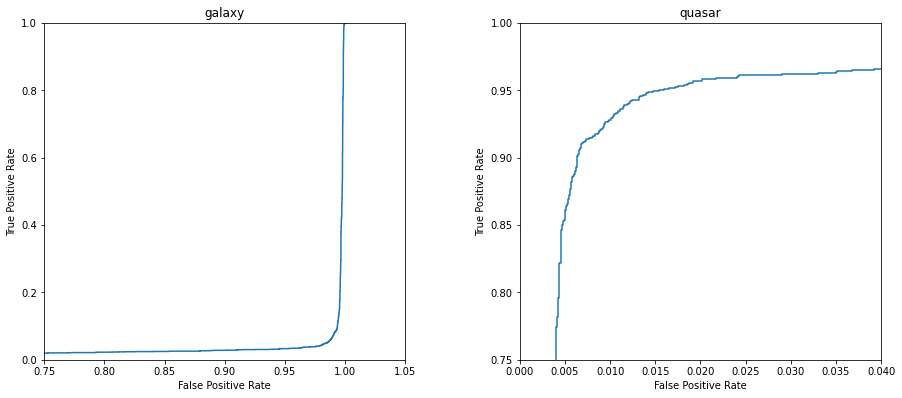

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i, obj in zip(range(0, 2), ['galaxy', 'quasar']):
    
    fpr, tpr, _ = roc_curve(y_validation, y_score_NB[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[i])
    
    axs[i].set_title(f"{obj}")
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")
axs[1].set_xlim(0, 0.04)  # the one used in the notebook

    
# better visualization:
    
axs[1].set_xlim(0, 0.04) 
axs[1].set_ylim(0.75, 1)  

axs[0].set_xlim(0.75, 1.05) 
axs[0].set_ylim(0, 1) 

plt.tight_layout(pad=6.0)

plt.show()

- N-dimensional analysis

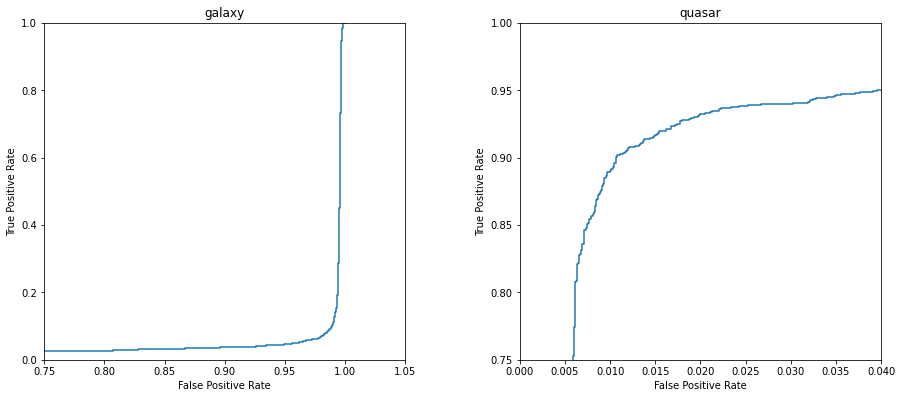

In [53]:
y_score_NB_AD = [nb_AD.predict_proba(X_validation_AD)[:, 0], nb_AD.predict_proba(X_validation_AD)[:, 1]]


fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i, obj in zip(range(0, 2), ['galaxy', 'quasar']):
    
    fpr, tpr, _ = roc_curve(y_validation_AD, y_score_NB_AD[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[i])
    
    axs[i].set_title(f"{obj}")
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")

# better visualization:
    
axs[1].set_xlim(0, 0.04) 
axs[1].set_ylim(0.75, 1)  

axs[0].set_xlim(0.75, 1.05) 
axs[0].set_ylim(0, 1) 

    
plt.tight_layout(pad=6.0)  # spacing between subplots

plt.show()

## ROC curve comparison

In the following section I used the suggested function of lecture 19 to plot all at once the ROC curves for different classifiers.

In [54]:
# Fit all the models to the training data
def compute_models(*args):
    names = []
    probs = []
    
    print('classifiers: ')
    print(' ')
    
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train[:, None], y_train)
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        y_probs = clf.predict_proba(X_validation[:, None])[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs

In [55]:
names, probs = compute_models((GaussianNB, {}),
                              (LDA, {}),
                              (QDA, {}),
                              (KNeighborsClassifier,
                               dict(n_neighbors=7)),
                              (GMMBayes, dict(n_components=4)))

classifiers: 
 
GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
KNeighborsClassifier
GMMBayes


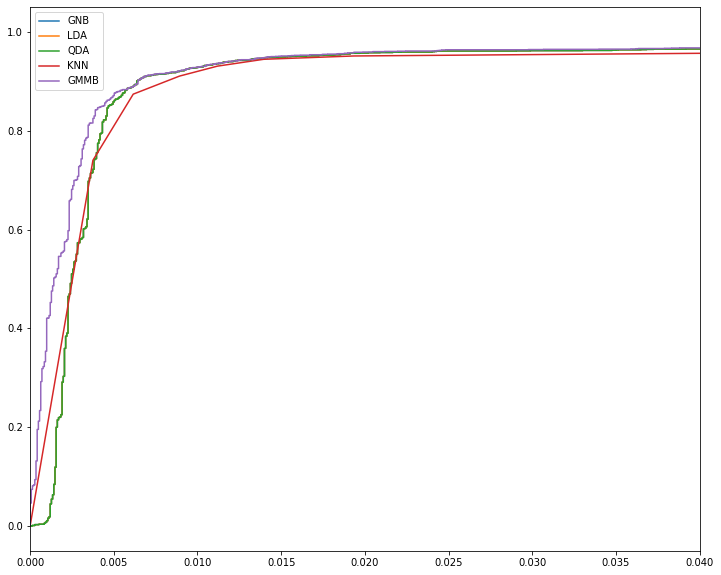

In [56]:
labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

plt.figure(figsize=(12, 10))

for name, y_prob in zip(names, probs):
    
    fpr, tpr, thresh = roc_curve(y_validation, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_validation, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    
    plt.plot(fpr, tpr, label=labels[name])
    
    plt.xlim(0, 0.04)
    
    plt.legend()

NB: this is only for quasars!

In [57]:
# Fit all the models to the training data
def compute_models_NDIM(*args):
    names = []
    probs = []
    
    print('classifiers: ')
    print(' ')
    
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train_AD, y_train_AD)
        
        #Note that we are outputing the probabilities [of class 1], not the classes!
        y_probs = clf.predict_proba(X_validation_AD)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs

In [58]:
names_NDIM, probs_NDIM = compute_models_NDIM((GaussianNB, {}),
                              (LDA, {}),
                              (QDA, {}),
                              (KNeighborsClassifier,
                               dict(n_neighbors=7)),
                              (GMMBayes, dict(n_components=4)))

classifiers: 
 
GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
KNeighborsClassifier
GMMBayes


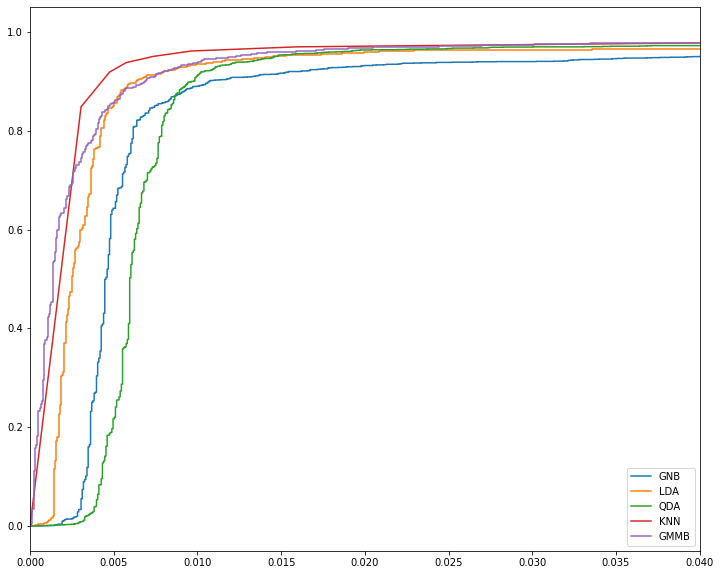

In [59]:
plt.figure(figsize=(12, 10))

for name, y_prob in zip(names_NDIM, probs_NDIM):
    
    fpr, tpr, thresh = roc_curve(y_validation_AD, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_validation_AD, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    
    plt.plot(fpr, tpr, label=labels[name])
    
    plt.xlim(0, 0.04)
    
    plt.legend()

# Run on different colors:

I choose to use the best classifier I could manage to find among the ones I used: GMMBayes. 

In [60]:
def compute_GMMbayes(Ncolors, Ncomp):
    
    classifiers = []
    predictions = []

    for ncm in Ncomp:
        
        classifiers.append([])
        predictions.append([])
        
        for nc in Ncolors:
            clf = GMMBayes(ncm)
            clf.fit(X_train_AD[:, :nc], y_train_AD)
            y_pred = clf.predict(X_validation_AD[:, :nc])

            classifiers[-1].append(clf)
            predictions[-1].append(y_pred)

    return classifiers, predictions

In [61]:
X_train, X_validation, y_train, y_validation = train_test_split(u_g, labels_z_o, test_size=0.33, random_state=1)

# AD == all data

X_train_AD, X_validation_AD, y_train_AD, y_validation_AD =  train_test_split(N_dim_dataset, labels_z_o, test_size=0.33, random_state=1)

In [62]:
Ncomp_gmmbayes = [5, 10, 15, 20]
c_name = ['ug-gr', 'ug-ri', 'ug-iz', 'gr-ri', 'ri-iz']
Ncolors = np.arange(1, N_dim_dataset.shape[1] + 1)

In [63]:
classifiers, predictions = compute_GMMbayes(Ncolors, Ncomp_gmmbayes)

completeness, contamination = completeness_contamination(predictions, y_validation_AD)

print("completeness", completeness)
print("contamination", contamination)

completeness [[0.94248531 0.93282955 0.934089   0.93492863]
 [0.94080605 0.94668346 0.94668346 0.94668346]
 [0.94080605 0.94206549 0.94626364 0.95256087]
 [0.94206549 0.94458438 0.94416457 0.95424013]]
contamination [[0.0730801  0.05446809 0.04136148 0.05635593]
 [0.07358413 0.06431535 0.05806182 0.04570461]
 [0.07089552 0.05634987 0.05214466 0.0498325 ]
 [0.07234394 0.0605428  0.04582096 0.04775869]]


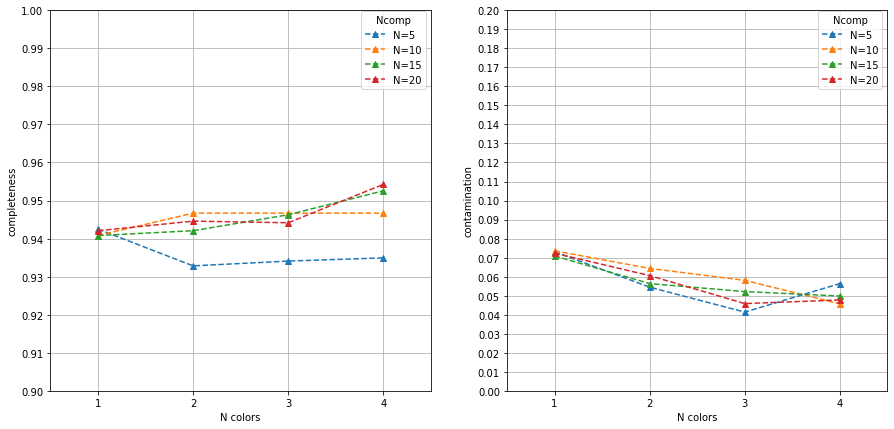

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# plot completeness vs Ncolors

for Ncomp, index in zip(Ncomp_gmmbayes, range(0, len(completeness))):

    ax[0].plot(Ncolors, completeness[index], '^--', ms=6, label='N=%i' % Ncomp)
    ax[0].legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.78), title='Ncomp')

ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[0].yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax[0].set_xlabel('N colors')
ax[0].set_ylabel('completeness')
ax[0].set_xlim(0.5, 4.5)
ax[0].set_ylim(0.9, 1.0)
ax[0].grid(True)

# plot contamination vs Ncolors

for Ncomp, index in zip(Ncomp_gmmbayes, range(0, len(contamination))):

    plt.plot(Ncolors, contamination[index], '^--', ms=6, label='N=%i' % Ncomp)
    plt.legend(loc='lower right',
    bbox_to_anchor=(1.0, 0.78), title='Ncomp')
    
ax[1].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[1].yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax[1].set_xlabel('N colors')
ax[1].set_ylabel('contamination')
ax[1].set_xlim(0.5, 4.5)
ax[1].set_ylim(0., 0.2)
ax[1].grid(True)

plt.show()

We see that adding up more and more colors does not change the completeness/contamination results. To understand if this happens because the first component (u-g color) is the relevant feature to the classification I try to produce the same plots with the possible colors combination, checking the completeness.  

In [65]:
def compute_GMMbayes_cComb(Ncolors, Ncomp):
    
    classifiers = []
    predictions = []
        
    classifiers.append([])
    predictions.append([])
    
    for colors_comb in Ncolors: 
    
        X_train_used = np.array((X_train_AD[:, colors_comb[0]], X_train_AD[:, colors_comb[1]])).T
        X_validation_used = np.array((X_validation_AD[:, colors_comb[0]], X_validation_AD[:, colors_comb[1]])).T
        
        clf = GMMBayes(Ncomp)
        clf.fit(X_train_used, y_train_AD)
        y_pred = clf.predict(X_validation_used)
        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

    return classifiers, predictions

In [66]:
# set only 1 Ncomp_Bayes to have less computational cost

Ncomp_bayes_1 = 19 # best one found before
c_combination = [[0, 1], [0, 2], [0, 3], [1, 2], [2, 3]]

In [67]:
classifiers_1, predictions_1 = compute_GMMbayes_cComb(c_combination, Ncomp_bayes_1)

completeness_1, contamination_1 = completeness_contamination(predictions_1, y_validation_AD)

print("completeness", completeness_1)
print("contamination", contamination_1)

completeness [[0.93744752 0.93786734 0.94626364 0.81402183 0.70361041]]
contamination [[0.05581395 0.05298855 0.0572982  0.1142074  0.19033816]]


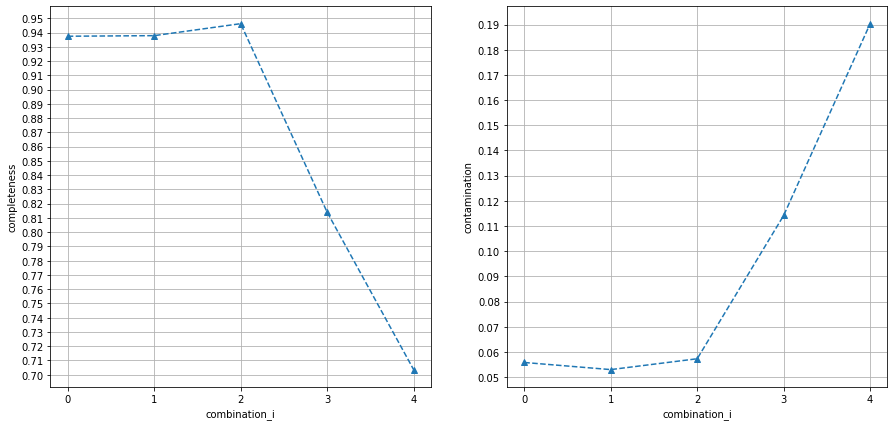

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# plot completeness vs Ncolors

ax[0].plot(range(0, len(c_combination)), completeness_1[0], '^--', ms=6, label='N=%i' % Ncomp)

ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[0].yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax[0].set_xlabel('combination_i')
ax[0].set_ylabel('completeness')
#ax[0].set_xlim(0.5, 4.5)
#ax[0].set_ylim(0.9, 1.0)
ax[0].grid(True)

# plot contamination vs Ncolors

ax[1].plot(range(0, len(c_combination)), contamination_1[0], '^--', ms=6, label='N=%i' % Ncomp)

ax[1].xaxis.set_major_locator(plt.MultipleLocator(1))
ax[1].yaxis.set_major_locator(plt.MultipleLocator(0.01))
ax[1].set_xlabel('combination_i')
ax[1].set_ylabel('contamination')
#ax[1].set_xlim(0.5, 4.5)
#ax[1].set_ylim(0., 0.2)
ax[1].grid(True)

plt.show()

From the above relation we can see how the important combinations are only the ones where the u-g color is one of the two. This means that the most important feature to take into the analysis is the u-g color. I have proved that analysing multiple colors doesn't change much of the results if the right one is included. 